In [0]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.utils import np_utils
from keras.regularizers import l2  #, activity_l2
import numpy
import csv
import scipy.misc
import scipy
from scipy import ndimage
import pandas as pd
# import imutils
# import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Conv2D
from keras.optimizers import Adadelta
from keras.utils import np_utils
from keras.regularizers import l2 #, activity_l2
import numpy
import csv
import scipy.misc
import scipy
from scipy import ndimage
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
# import dataprocessing

from google.colab import drive
drive.mount('/content/gdrive')


# data =pd.read_csv('gdrive/My Drive/fer2013.csv')

def flatten_matrix(matrix):
    vector = matrix.flatten(1)
    vector = vector.reshape(1, len(vector))
    return vector

def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1                #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #ZCA Whitening matrix
    return np.dot(ZCAMatrix, inputs)   #Data whitening

def global_contrast_normalize(X, scale=1., subtract_mean=True, use_std=True,
                              sqrt_bias=10, min_divisor=1e-8):
    assert X.ndim == 2, "X.ndim must be 2"
    scale = float(scale)
    assert scale >= min_divisor

    mean = X.mean(axis=1)
    if subtract_mean:
        X = X - mean[:, numpy.newaxis]
    else:
        X = X.copy()
    if use_std:
        ddof = 1
        if X.shape[1] == 1:
            ddof = 0
        normalizers = numpy.sqrt(sqrt_bias + X.var(axis=1, ddof=ddof)) / scale
    else:
        normalizers = numpy.sqrt(sqrt_bias + (X ** 2).sum(axis=1)) / scale
    normalizers[normalizers < min_divisor] = 1.
    X /= normalizers[:, numpy.newaxis]  # Does not make a copy.
    return X
def ZeroCenter(data):
    data = data - numpy.mean(data,axis=0)
    return data

def normalize(arr):
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (255.0/(maxval-minval))
    return arr

def Flip(data):
    dataFlipped = data[..., ::-1].reshape(2304).tolist()
    return dataFlipped

# def Roated15Left(data):
#     num_rows, num_cols = data.shape[:2]
#     rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
#     img_rotation = cv2.warpAffine(data, rotation_matrix, (num_cols, num_rows))
#     return img_rotation.reshape(2304).tolist()

# def Roated15Right(data):
#     num_rows, num_cols = data.shape[:2]
#     rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), -30, 1)
#     img_rotation = cv2.warpAffine(data, rotation_matrix, (num_cols, num_rows))
#     return img_rotation.reshape(2304).tolist()

def Zoomed(data):
    datazoomed = scipy.misc.imresize(data,(60,60))
    datazoomed = datazoomed[5:53,5:53]
    datazoomed = datazoomed.reshape(2304).tolist()
    return datazoomed

# def shiftedUp20(data):
#     translated = imutils.translate(data, 0, -5)
#     translated2 = translated.reshape(2304).tolist()
#     return translated2
# def shiftedDown20(data):
#     translated = imutils.translate(data, 0, 5)
#     translated2 = translated.reshape(2304).tolist()
#     return translated2

# def shiftedLeft20(data):
#     translated = imutils.translate(data, -5, 0)
#     translated2 = translated.reshape(2304).tolist()
#     return translated2
# def shiftedRight20(data):
#     translated = imutils.translate(data, 5, 0)
#     translated2 = translated.reshape(2304).tolist()
#     return translated2

def outputImage(pixels,number):
    data = pixels
    name = str(number)+"output.jpg"
    scipy.misc.imsave(name, data)

def Zerocenter_ZCA_whitening_Global_Contrast_Normalize(list):
    Intonumpyarray = numpy.asarray(list)
    data = Intonumpyarray.reshape(48,48)
    data2 = ZeroCenter(data)
    data3 = zca_whitening(flatten_matrix(data2)).reshape(48,48)
    data4 = global_contrast_normalize(data3)
    data5 = numpy.rot90(data4,3)
    return data5

def load_test_data():
    f = open('gdrive/My Drive/machine learning/fer2013.csv')
    csv_f = csv.reader(f)
    test_set_x =[]
    test_set_y =[]
    for row in csv_f:
        if str(row[2]) == "PrivateTest" :
            test_set_y.append(int(row[0]))
            temp_list = []
            for pixel in row[1].split( ):
                temp_list.append(int(pixel))
            data = Zerocenter_ZCA_whitening_Global_Contrast_Normalize(temp_list)
            test_set_x.append(data)
    return test_set_x, test_set_y

def load_data():

    train_x = []
    train_y = []
    val_x =[]
    val_y =[]
    test_x =[]
    test_y =[]

    with open("gdrive/My Drive/machine learning/badtrainingdata.txt", "r") as text:
        ToBeRemovedTrainingData = []
        for line in text:
            ToBeRemovedTrainingData.append(int(line))
    number = 0

    f = open('gdrive/My Drive/machine learning/fer2013.csv')
    csv_f = csv.reader(f)

    for row in csv_f:
        number+= 1
        if number not in ToBeRemovedTrainingData:

            if str(row[2]) == "Training" :
                temp_list = []

                for pixel in row[1].split( ):
                    temp_list.append(int(pixel))

                data = Zerocenter_ZCA_whitening_Global_Contrast_Normalize(temp_list)
                train_y.append(int(row[0]))
                train_x.append(data.reshape(2304).tolist())

            elif str(row[2]) == "PublicTest":
                temp_list = []

                for pixel in row[1].split( ):
                    temp_list.append(int(pixel))

                data = Zerocenter_ZCA_whitening_Global_Contrast_Normalize(temp_list)
                val_y.append(int(row[0]))
                val_x.append(data.reshape(2304).tolist())
            elif str(row[2]) == "PrivateTest":
                temp_list = []

                for pixel in row[1].split( ):
                    temp_list.append(int(pixel))

                data = Zerocenter_ZCA_whitening_Global_Contrast_Normalize(temp_list)
                test_y.append(int(row[0]))
                test_x.append(data.reshape(2304).tolist())

    return train_x, train_y, val_x, val_y, test_x, test_y

  

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:

def model_generate():
    img_rows, img_cols = 48, 48
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 1), padding = 'same',bias_initializer='zeros', kernel_initializer='he_uniform'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same',bias_initializer='zeros', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides =2))

    model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same',bias_initializer='zeros', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same',bias_initializer='zeros', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides =2))

    model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same',bias_initializer='zeros', kernel_initializer='he_uniform'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same',bias_initializer='zeros', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides =2))


    model.add(Conv2D(256, (3, 3), activation='relu', padding = "same",bias_initializer='zeros', kernel_initializer='he_uniform'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding = "same",bias_initializer='zeros', kernel_initializer='he_uniform'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding = "same",bias_initializer='zeros', kernel_initializer='he_uniform'))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7))      
    model.add(Activation('softmax'))

    ada = Adadelta(lr=0.1, rho=0.95, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer=ada,
                  metrics=['accuracy'])
    model.summary()
    return model
img_rows, img_cols = 48, 48
batch_size = 128
nb_classes = 7
nb_epoch = 300
img_channels = 1

# data =pd.read_csv('gdrive/My Drive/machine learning/fer2013.csv')
# data.head()   
# pixels = data['pixels'].tolist()
# final_pixels_list=[]
# for i in range(len(pixels)):
#       pixels1=pixels[i].split()
#       results = [int(j) for j in pixels1]
#       arr = np.array(pixels1)
#       array=array.reshape(48,48,1)
#       arr = np.array(array, dtype=np.uint8)
#       final_pixels_list.append(array)     
# training_count=0
# testing_count=0
# for i in range(len(pixels)):
#      if data['Usage'][i]=="Training":
#           training_count=training_count+1
#      else:
#           testing_count=testing_count+1   

# print(training_count)
# print(testing_count)
# print(data.tail())
# test_output=data['emotion'].tolist()
# for i in range(len(test_output)):
#      test_output[i]=int(test_output[i])
# encoded = np_utils.to_categorical(test_output)
# test_output=encoded
# X_train=final_pixels_list[0:training_count]
# X_test=final_pixels_list[training_count:len(final_pixels_list)]
# y_train=test_output[0:training_count]
# y_test=test_output[training_count:len(final_pixels_list)]
# print(len(X_train))
# print(len(X_test))
# print((y_train.shape))
# print(len(y_test))

Train_x, Train_y, Val_x, Val_y, Test_x, Test_y = load_data()

Train_x = numpy.asarray(Train_x)
Train_x = Train_x.reshape(Train_x.shape[0],img_rows,img_cols)

Val_x = numpy.asarray(Val_x)
Val_x = Val_x.reshape(Val_x.shape[0],img_rows,img_cols)

Test_x = numpy.asarray(Test_x)
Test_x = Test_x.reshape(Test_x.shape[0],img_rows,img_cols)

Train_x = Train_x.reshape(Train_x.shape[0], img_rows, img_cols,1)
Val_x = Val_x.reshape(Val_x.shape[0], img_rows, img_cols,1)
Test_x = Test_x.reshape(Test_x.shape[0], img_rows, img_cols,1)

Train_x = Train_x.astype('float32')
Val_x = Val_x.astype('float32')
Test_x = Test_x.astype('float32')


Train_y = np_utils.to_categorical(Train_y, nb_classes)
Val_y = np_utils.to_categorical(Val_y, nb_classes)
Test_y = np_utils.to_categorical(Test_y, nb_classes)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


In [0]:

model = model_generate()
steps_per_epoch = int(len(Train_x)/batch_size)
# model.load_weights('gdrive/My Drive/machine learning/models_vgg12/model-vgg12-cnn_+242.149-0.6329.hdf5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 128)       73856     
__________

In [0]:

# filepath='gdrive/My Drive/machine learning/models_vgg12_new/model-vgg12-cnn.{epoch:02d}-{val_acc:.4f}.hdf5'
# checkpointer = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(np.array(Train_x))

history = model.fit_generator(datagen.flow(Train_x,Train_y,
                    batch_size=batch_size),
                    steps_per_epoch=steps_per_epoch,
                    nb_epoch=nb_epoch,
                    validation_data=(Val_x, Val_y))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=223, validation_data=(array([[[..., epochs=300)`


Epoch 1/300
223/223 [==============================] - 25s 112ms/step - loss: 1.8703 - acc: 0.2125 - val_loss: 1.8084 - val_acc: 0.2494
Epoch 2/300
223/223 [==============================] - 20s 91ms/step - loss: 1.8396 - acc: 0.2298 - val_loss: 1.7942 - val_acc: 0.2494
Epoch 3/300
223/223 [==============================] - 20s 89ms/step - loss: 1.8302 - acc: 0.2366 - val_loss: 1.7876 - val_acc: 0.2502
Epoch 4/300
223/223 [==============================] - 20s 90ms/step - loss: 1.8176 - acc: 0.2467 - val_loss: 1.7672 - val_acc: 0.2753
Epoch 5/300
223/223 [==============================] - 20s 90ms/step - loss: 1.8044 - acc: 0.2531 - val_loss: 1.7518 - val_acc: 0.2884
Epoch 6/300
223/223 [==============================] - 20s 90ms/step - loss: 1.7927 - acc: 0.2622 - val_loss: 1.7246 - val_acc: 0.2904
Epoch 7/300
223/223 [==============================] - 20s 90ms/step - loss: 1.7759 - acc: 0.2723 - val_loss: 1.7187 - val_acc: 0.3219
Epoch 8/300
223/223 [==============================] -

KeyboardInterrupt: ignored

In [0]:
print(history)

NameError: ignored

In [0]:

score = model.evaluate(Test_x, Test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1313065001312888
Test accuracy: 0.639732516054391


In [0]:
scores = model.evaluate(Test_x, Test_y, verbose=0,batch_size=batch_size)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

Loss: 1.1313062344098297
Accuracy: 0.639732516054391


In [0]:
score = model.evaluate(Test_x, Test_y, verbose=0, steps=int(len(Test_x)/batch_size))
print("Test Loss: " + str(scores[0]))
print("Test Accuracy: " + str(scores[1]))



Test Loss: 1.1313062344098297
Test Accuracy: 0.639732516054391


In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(np.array(Train_x))

test_flow = datagen.flow(Test_x,Test_y, batch_size=1, shuffle=False)
    
nb_samples = len(test_flow)
test_flow_scores = model.evaluate_generator(test_flow, steps=nb_samples)

print("test_flow Loss: " + str(test_flow_scores[0]))
print("test_flow Accuracy: " + str(test_flow_scores[1]))


test_flow Loss: 1.0692662706500808
test_flow Accuracy: 0.6299804959598774


In [0]:
from keras.models import model_from_json
# json_file = open('model.json', 'r')
# model = json_file.read()
# json_file.close()
# loaded_model = model_from_json(model)
# load weights into new model
# model.load_weights("model.h5")
print("Loaded model from disk")

print(model.layers[9])

Loaded model from disk


[[0.21306323 0.02364848 0.30717847 0.01640384 0.31572855 0.03669681
  0.08728064]]
[0. 0. 0. 0. 1. 0. 0.]
4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


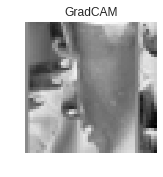

In [0]:
from keras import backend as K
import cv2

from matplotlib import pyplot as plt

predictions = model.predict(np.array(Train_x[4147]).reshape(1,48,48,1))
print(predictions)
print(Train_y[4147])
cls=np.argmax(predictions)
print(cls)
y_c = model.output[0, cls]
#print(y_c)
#print(loaded_model.layers[6])
conv_output = model.layers[9].output
grads = K.gradients(y_c, conv_output)[0]
#print(grads)
gradient_function = K.function([model.input], [conv_output, grads])

output, grads_val = gradient_function([np.array(Train_x[4147]).reshape(1,48,48,1)])
output, grads_val = output[0, :], grads_val[0, :, :, :]
weights = np.mean(grads_val, axis=(0, 1))
cam = np.dot(output, weights)
cam = cv2.resize(cam, (48, 48), cv2.INTER_LINEAR)
cam = np.maximum(cam, 0)
cam = cam / cam.max()


plt.figure(figsize=(8, 8))
plt.subplot(131)
plt.title('GradCAM')
plt.axis('off')
#plt.imshow(load_image(img_path, preprocess=False))
plt.imshow(Train_x[4147].reshape(48,48))
plt.imshow(cam, cmap='jet', alpha=0.5)

(48, 48)


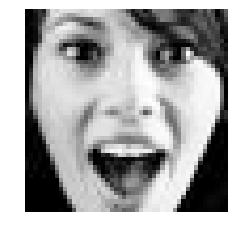

In [0]:
import math
import skimage.io
import skimage.transform
import skimage.filters



def tensor_summary(tensor):
    """Display shape, min, and max values of a tensor."""
    print("shape: {}  min: {}  max: {}".format(tensor.shape, tensor.min(), tensor.max()))

    
def normalize(image):
    """Takes a tensor of 3 dimensions (height, width, colors) and normalizes it's values
    to be between 0 and 1 so it's suitable for displaying as an image."""
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)

def display_images(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
    """
    images: A list of images. I can be either:
        - A list of Numpy arrays. Each array represents an image.
        - A list of lists of Numpy arrays. In this case, the images in
          the inner lists are concatentated to make one image.
    """
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(8, 8 * height_ratio))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Is image a list? If so, merge them into one image.
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1



image = skimage.io.imread('gdrive/My Drive/machine learning/4147.jpg')
print(image.shape)
#assert image.shape == (48, 48, 1),"must be 48x48 gray scale image"
#tensor_summary(image)
display_images([image], cols=2)

In [0]:



arr=image.reshape(48,48,1)
print(arr.shape)


# Convert image to float
x = arr.astype(np.float32)
# Make it a batch of one. The model expects a batch, not a single image
x = x[np.newaxis,...]

print(x.shape)



# Classify the image
predictions = model.predict(x)
# We'll get a 1000 values. Print the first 10.
print(predictions)

# Find the largest confidence value. This corresponds to the label index.
label_index = np.argmax(predictions)
print("label index: ", label_index)


(48, 48, 1)
(1, 48, 48, 1)
[[0. 0. 0. 1. 0. 0. 0.]]
label index:  3


In [0]:
weights = model.get_layer("conv2d_3").get_weights()[0]
weights.shape, weights.min(), weights.max()

print(weights.shape)

display_images([weights[:,:,0,i] for i in range(32)], cols=16, interpolation="none")

ValueError: ignored

In [0]:
def read_layer(model, x, layer_name):
    """Return the activation values for the specifid layer"""
    # Create Keras function to read the output of a specific layer
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([x])[0]
    tensor_summary(outputs)
    return outputs[0]
    
def view_layer(model, x, layer_name, cols=8):
    outputs = read_layer(model, x, layer_name)
    display_images([outputs[:,:,i] for i in range(256)], cols=cols)

In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 128)       73856     
__________

shape: (1, 48, 48, 32)  min: 0.0  max: 410.9939880371094


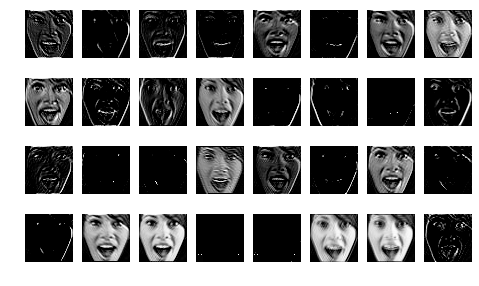

In [0]:
view_layer(model, x, "conv2d_1")

shape: (1, 48, 48, 32)  min: 0.0  max: 367.90838623046875


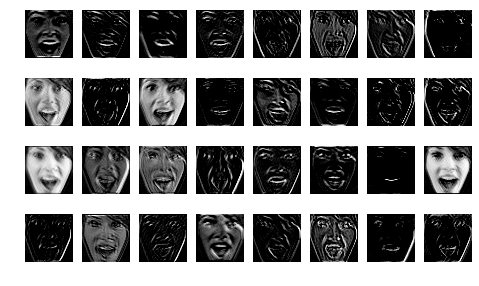

In [0]:
view_layer(model, x, "conv2d_2")

shape: (1, 24, 24, 64)  min: 0.0  max: 586.145263671875


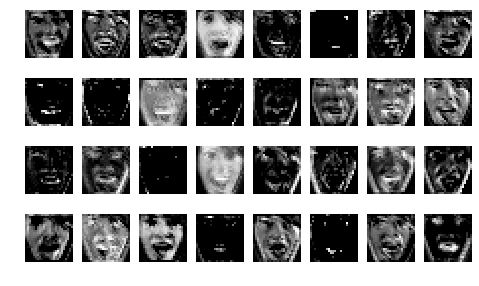

In [0]:
view_layer(model, x, "conv2d_3")

shape: (1, 24, 24, 64)  min: 0.0  max: 623.8717041015625


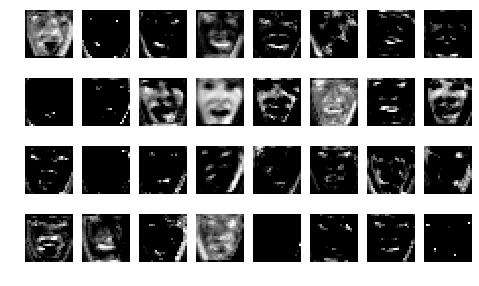

In [0]:
view_layer(model, x, "conv2d_5")

shape: (1, 6, 6, 256)  min: 0.0  max: 673.0057983398438


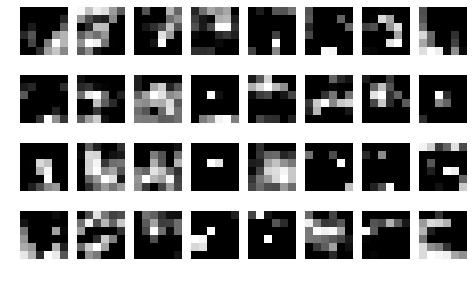

In [0]:
view_layer(model, x, "conv2d_8")

shape: (1, 6, 6, 256)  min: 0.0  max: 857.439697265625


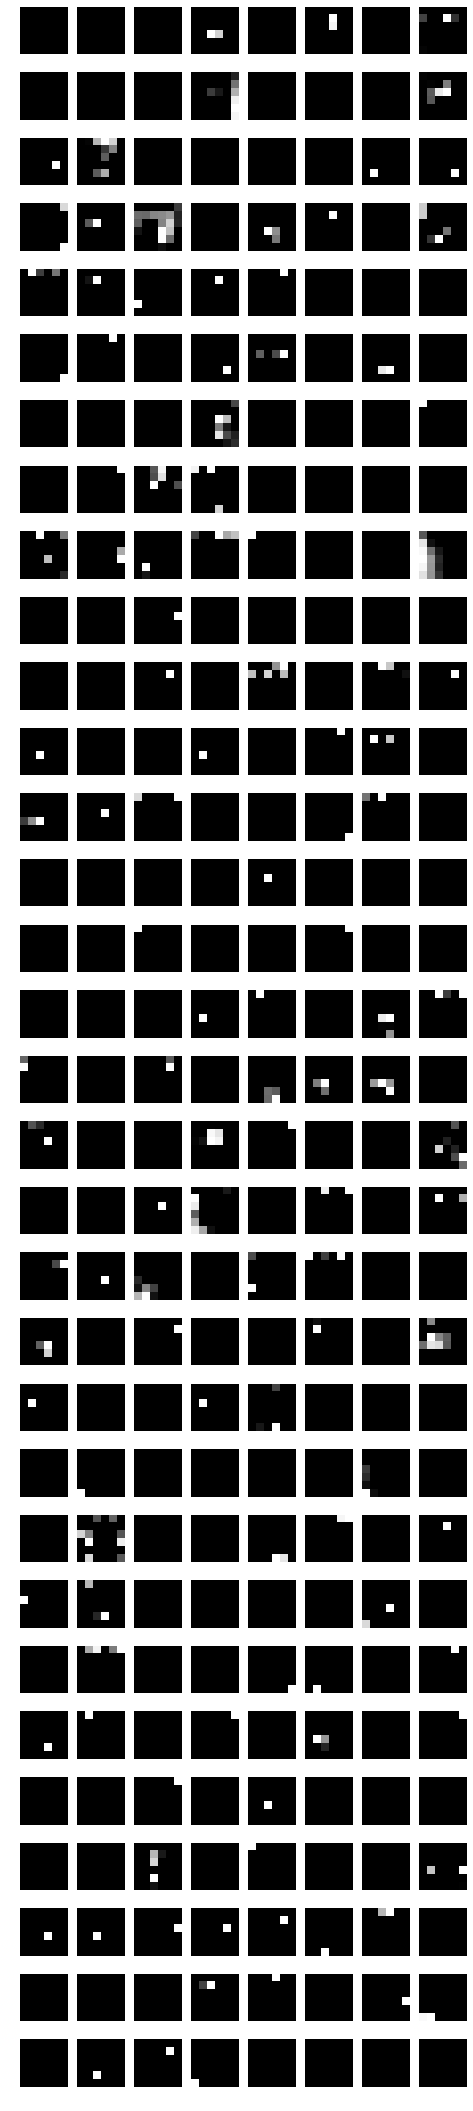

In [0]:
view_layer(model, x, "conv2d_9")

In [0]:
y_prob = model.predict(Test_x, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in Test_y]

print(y_prob.shape)
print(len(y_pred))
print(len(Test_y))

emotion = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

(3589, 7)
3589
3589


[3.7359882e-06 1.4780988e-14 3.8422240e-08 9.9977630e-01 3.4630014e-07
 3.8507416e-08 2.1961278e-04]
[0. 0. 0. 1. 0. 0. 0.]
3
1/1 [==============================] - 0s 5ms/step
1.0


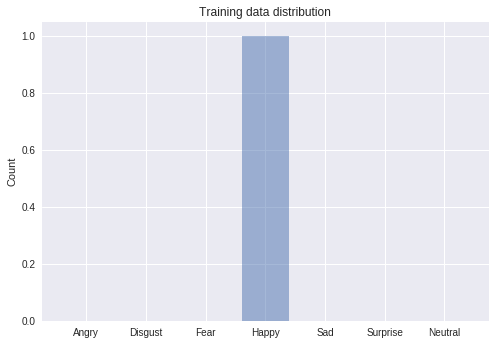

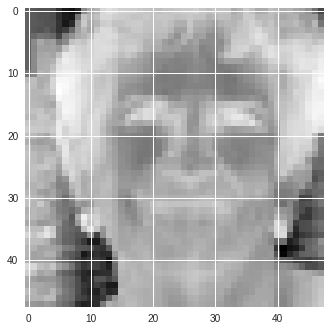

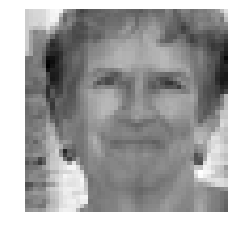

In [0]:
input_img = Test_x[20].reshape(48,48)

y_pos = np.arange(1)
objects = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise','Neutral')
y_pos = np.arange(len(objects))
performance=y_prob[20]
print(performance)
print(Test_y[20])
print(y_pred[20])
scores = model.evaluate(Test_x[20].reshape((1,48,48,1)),Test_y[20].reshape(1,7))
print(scores[1])

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Training data distribution')
 
plt.show()

plt.imshow(input_img)
plt.show()


display_images([input_img], cols=2)

[0.04 0.01 0.3  0.14 0.05 0.41 0.06]
acc:  [0. 0. 0. 0. 0. 1. 0.]
5
1/1 [==============================] - 0s 5ms/step
1.0


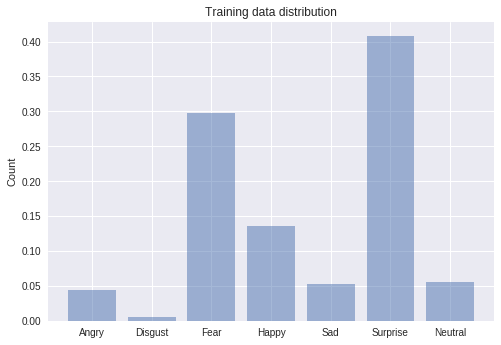

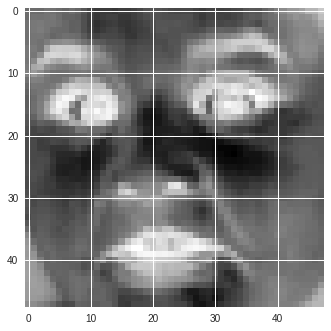

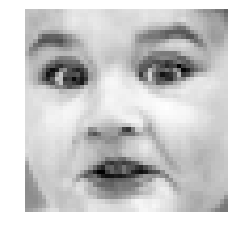

In [0]:

input_img = Test_x[36].reshape(48,48)

y_pos = np.arange(1)
objects = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise','Neutral')
y_pos = np.arange(len(objects))
performance=y_prob[36]
print(performance)
print("acc: ", Test_y[36])
print(y_pred[36])
scores = model.evaluate(Test_x[36].reshape((1,48,48,1)),Test_y[36].reshape(1,7))
print(scores[1])

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Training data distribution')
 
plt.show()

plt.imshow(input_img)
plt.show()

# image = skimage.io.imread('gdrive/My Drive/machine learning/4147.jpg')
# print(image.shape)
# #assert image.shape == (48, 48, 1),"must be 48x48 gray scale image"
# #tensor_summary(image)
display_images([input_img], cols=2)

[[268   4  62  25  57  14  61]
 [ 20  24   4   1   1   1   4]
 [ 73   2 215  26  80  61  71]
 [ 20   0  17 760  12  21  49]
 [ 65   1  72  40 244  13 159]
 [  6   1  41  22   2 330  14]
 [ 35   4  26  34  53  19 455]]


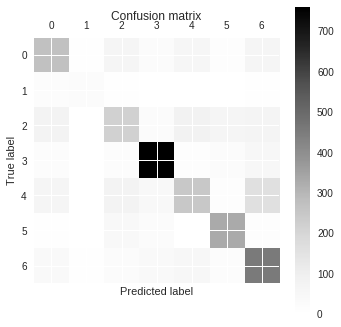

In [0]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.array(Test_y).argmax(axis=1), np.array(y_prob).argmax(axis=1))

print(cm)

# Show confusion matrix in a separate window
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[268   4  62  25  57  14  61]
 [ 20  24   4   1   1   1   4]
 [ 73   2 215  26  80  61  71]
 [ 20   0  17 760  12  21  49]
 [ 65   1  72  40 244  13 159]
 [  6   1  41  22   2 330  14]
 [ 35   4  26  34  53  19 455]]
Normalized confusion matrix
[[0.55 0.01 0.13 0.05 0.12 0.03 0.12]
 [0.36 0.44 0.07 0.02 0.02 0.02 0.07]
 [0.14 0.   0.41 0.05 0.15 0.12 0.13]
 [0.02 0.   0.02 0.86 0.01 0.02 0.06]
 [0.11 0.   0.12 0.07 0.41 0.02 0.27]
 [0.01 0.   0.1  0.05 0.   0.79 0.03]
 [0.06 0.01 0.04 0.05 0.08 0.03 0.73]]


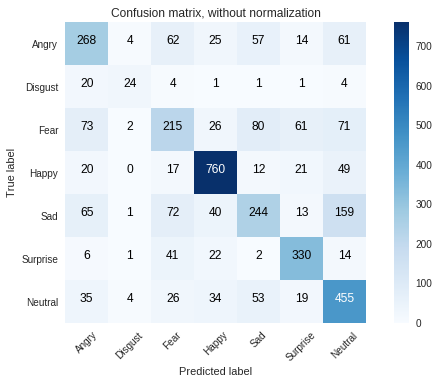

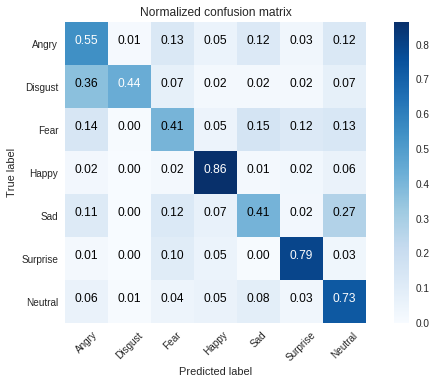

In [0]:
# Compute confusion matrix
cnf_matrix = cm
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(objects),
                      title='Confusion matrix, without normalization')
plt.grid('off')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(objects), normalize=True,
                      title='Normalized confusion matrix')


plt.grid('off')

plt.show()

In [0]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(Test_y[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Test_y.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

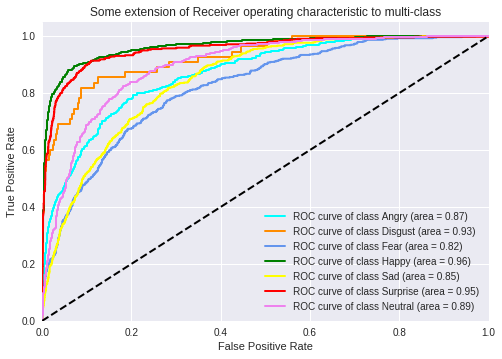

In [0]:
# Compute macro-average ROC curve and ROC area
from scipy import interp
from itertools import cycle

lw=2

n_classes =7
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','yellow','red','violet'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(emotion[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [0]:
from scipy.ndimage.interpolation import zoom
number=0

for number in range(30):
      print(number)
      predictions = loaded_model.predict(np.array(Test_x[number]).reshape(1,48,48,1))
      print(predictions)
      print(Test_y[number])
      cls = np.argmax(loaded_model.predict(np.array(Test_x[number]).reshape(1,48,48,1)))
      print(cls)
      if np.argmax(Test_y[number])==cls:
        print("yes")
      else:
        print("No")
      y_c = loaded_model.output[0, cls]
      conv_output = loaded_model.layers[6].output

      grads = K.gradients(y_c, conv_output)[0]

      first = K.exp(y_c)*grads
      second = K.exp(y_c)*grads*grads
      third = K.exp(y_c)*grads*grads

      gradient_function = K.function([loaded_model.input], [y_c,first,second,third, conv_output, grads])
      y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([np.array(X_test[number]).reshape(1,48,48,1)])
      global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

      alpha_num = conv_second_grad[0]
      alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
      alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
      alphas = alpha_num/alpha_denom

      weights = np.maximum(conv_first_grad[0], 0.0)

      alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)

      alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))

      deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
      grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

          # Passing through ReLU
      cam = np.maximum(grad_CAM_map, 0)
      cam = zoom(cam,48/cam.shape[0])
      cam = cam / np.max(cam) # scale 0 to 1.0   
      plt.figure(figsize=(8, 8))
      plt.subplot(131)
      plt.title('GradCAM')
      plt.axis('off')
      #plt.imshow(load_image(img_path, preprocess=False))
      plt.imshow(X_test[number].reshape(48,48))
      plt.imshow(cam, cmap='jet', alpha=0.4)
      plt.show()

In [0]:
print("Classification report for classifier %s:\n%s\n" % (model, metrics.classification_report(Test_y, y_pred)))
